<font color="red" size=5><center>PyAlink-Svm model in Flink Node </center></font>

# 数据读取

In [1]:
from pyalink.alink import *
resetEnv()
# useLocalEnv(1, config=None) #本地运行
useRemoteEnv("192.168.10.102", 8081, 2) #集群运行


Use one of the following commands to start using PyAlink:
 - useLocalEnv(parallelism, flinkHome=None, config=None): run PyAlink scripts locally.
 - useRemoteEnv(host, port, parallelism, flinkHome=None, localIp="localhost", config=None): run PyAlink scripts on a Flink cluster.
 - getMLEnv(): run PyAlink scripts as PyFlink scripts, support 'flink run -py xxx.py'.
Call resetEnv() to reset environment and switch to another.

JVM listening on 127.0.0.1:62402


MLEnv(benv=<pyflink.dataset.execution_environment.ExecutionEnvironment object at 0x000001615F7BED00>, btenv=<pyflink.table.table_environment.BatchTableEnvironment object at 0x000001615F7BEDF0>, senv=<pyflink.datastream.stream_execution_environment.StreamExecutionEnvironment object at 0x000001615F7BEB20>, stenv=<pyflink.table.table_environment.StreamTableEnvironment object at 0x000001615F7DF520>)

In [2]:
from utils import *
import os
import pandas as pd
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 1000)#最大显示列宽

DATA_DIR = ROOT_DIR + "banknote" + os.sep

ORIGIN_FILE = "data_banknote_authentication.txt"

SCHEMA_STRING = "variance double, skewness double, kurtosis double, entropy double, class int"#定义变量和类型

TRAIN_FILE = "train.ak"
TEST_FILE = "test.ak"
LR_PRED_FILE = "lr_pred.ak"
SVM_PRED_FILE = "svm_pred.ak"

FEATURE_COL_NAMES = ["variance", "skewness", "kurtosis", "entropy"]
LABEL_COL_NAME = "class"

VEC_COL_NAME = "vec"

PREDICTION_COL_NAME = "pred"
PRED_DETAIL_COL_NAME = "predinfo"

In [3]:
df= pd.read_csv('G:\\pythondataanalysis\\PyFlink\\alink_data\\banknote\\data_banknote_authentication.txt', sep=',', header=None)
df.columns = ["variance","skewness","kurtosis","entropy","class"]

In [4]:
df

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [5]:
#数据读取

#读取批式csv文件/设置文件路径/定义变量和类型
#source = CsvSourceBatchOp().setFilePath(DATA_DIR + ORIGIN_FILE).setSchemaStr(SCHEMA_STRING)
source=BatchOperator.fromDataframe(df,schemaStr=SCHEMA_STRING)

print("column names of source:")
print(source.getColNames())

print("column types of source:")
print(source.getColTypes())

source.firstN(5).print()

column names of source:
['variance', 'skewness', 'kurtosis', 'entropy', 'class']
column types of source:
['DOUBLE', 'DOUBLE', 'DOUBLE', 'DOUBLE', 'INT']


,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [6]:
#数据摘要

summary = SummarizerBatchOp().linkFrom(source).collectSummary()
print("Count of data set : " + str(summary.count()))
print("Max value of entropy : " + str(summary.max("entropy")))
print(summary)

source.link(
    SummarizerBatchOp()\
        .lazyCollectSummary(
            lambda tableSummary:(
                print("Count of data set : " + str(tableSummary.count())),
                print("Max value of entropy : " + str(tableSummary.max("entropy"))),
                print(tableSummary)
            )
        )
)

source.link(
    SummarizerBatchOp().lazyPrintSummary()
)

source\
    .lazyPrintStatistics("<- origin data ->")\
    .firstN(5)\
    .lazyPrintStatistics("<- first 5 data ->")\
    .print()

Count of data set : 1372
Max value of entropy : 2.4495
Summary: 
| colName|count|missing|       sum|   mean|variance|     min|    max|
|--------|-----|-------|----------|-------|--------|--------|-------|
|variance| 1372|      0|  595.0848| 0.4337|  8.0813| -7.0421| 6.8248|
|skewness| 1372|      0| 2637.4685| 1.9224| 34.4457|-13.7731|12.9516|
|kurtosis| 1372|      0| 1917.5444| 1.3976| 18.5764| -5.2861|17.9274|
| entropy| 1372|      0|-1634.9527|-1.1917|  4.4143| -8.5482| 2.4495|
|   class| 1372|      0|       610| 0.4446|  0.2471|       0|      1|

Count of data set : 1372
Max value of entropy : 2.4495
Summary: 
| colName|count|missing|       sum|   mean|variance|     min|    max|
|--------|-----|-------|----------|-------|--------|--------|-------|
|variance| 1372|      0|  595.0848| 0.4337|  8.0813| -7.0421| 6.8248|
|skewness| 1372|      0| 2637.4685| 1.9224| 34.4457|-13.7731|12.9516|
|kurtosis| 1372|      0| 1917.5444| 1.3976| 18.5764| -5.2861|17.9274|
| entropy| 1372|      0|-1634

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [7]:
#变量相关性分析

correlation = CorrelationBatchOp().linkFrom(source).collectCorrelation()
colNames = correlation.getColNames()
print("Correlation of " + colNames[0] + " with " + colNames[1] 
      + " is " + str(correlation.getCorrelation()[0][1]));
print(correlation.getCorrelationMatrix())


def print_correlation_info(correlationResult: CorrelationResult):
    colNames = correlationResult.getColNames()
    print("Correlation of " + colNames[0] + " with " + colNames[1]
          + " is " + str(correlationResult.getCorrelation()[0][1]))
    print(correlationResult.getCorrelationMatrix())

    
source\
    .link(
        CorrelationBatchOp()\
            .lazyCollectCorrelation(print_correlation_info)
    )

source.link(
    CorrelationBatchOp().lazyPrintCorrelation("< Pearson Correlation >")
)

source.link(
    CorrelationBatchOp()\
        .setMethod("SPEARMAN")\
        .lazyPrintCorrelation("< Spearman Correlation >")
)

BatchOperator.execute()

Correlation of variance with skewness is 0.2640255299704367
mat[5,5]:
  1.0,0.2640255299704367,-0.38084997204625287,0.27681669600536374,-0.7248431424446055
  0.2640255299704367,1.0,-0.7868952243065814,-0.5263208425437155,-0.4446877575965933
  -0.38084997204625287,-0.7868952243065814,1.0,0.3188408876874461,0.15588323600923046
  0.27681669600536374,-0.5263208425437155,0.3188408876874461,1.0,-0.02342367895485178
  -0.7248431424446055,-0.4446877575965933,0.15588323600923046,-0.02342367895485178,1.0

Correlation of variance with skewness is 0.2640255299704367
mat[5,5]:
  1.0,0.2640255299704367,-0.38084997204625287,0.27681669600536374,-0.7248431424446055
  0.2640255299704367,1.0,-0.7868952243065814,-0.5263208425437155,-0.4446877575965933
  -0.38084997204625287,-0.7868952243065814,1.0,0.3188408876874461,0.15588323600923046
  0.27681669600536374,-0.5263208425437155,0.3188408876874461,1.0,-0.02342367895485178
  -0.7248431424446055,-0.4446877575965933,0.15588323600923046,-0.02342367895485178,1.0

## 可视化分析

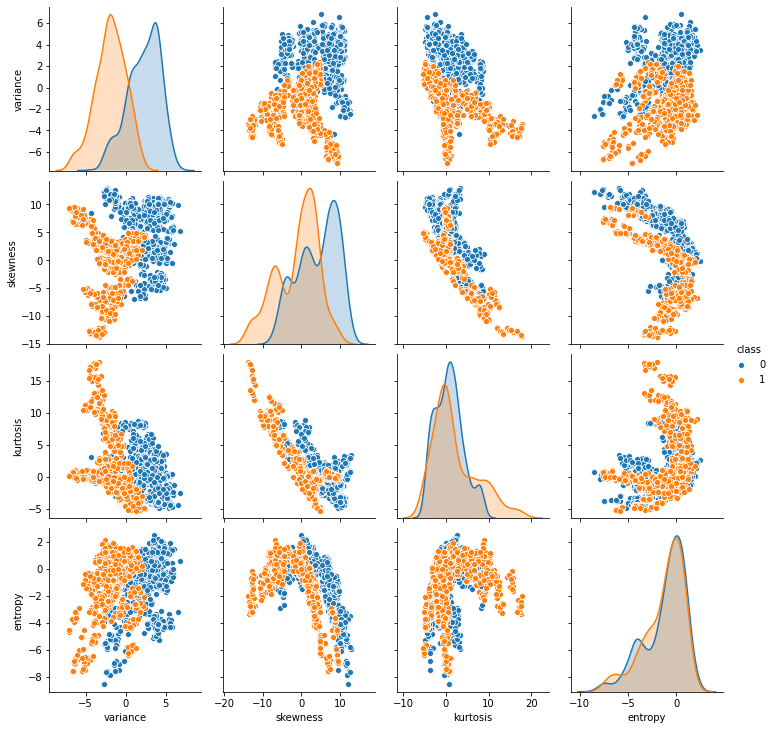

In [8]:
#使用plt进行可视化分析
import matplotlib.pyplot as plt
import seaborn as sns

df_banknote = source.collectToDataframe()

sns.pairplot(df_banknote, vars = df_banknote.columns[:-1], hue = 'class')

plt.show()

D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


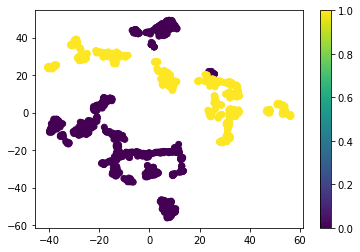

In [9]:
#密度可视化
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, learning_rate = 100).fit_transform(df_banknote.iloc[:, 0:4])

plt.scatter(tsne[:, 0], tsne[:, 1], c = df_banknote.iloc[:, 4])
plt.colorbar()
plt.show()

# 模型建立

## 划分数据集

In [10]:
#划分训练集和测试集8：2
#train_data,test_data=splitTrainTestIfNotExist(source, DATA_DIR + TRAIN_FILE, DATA_DIR + TEST_FILE, 0.8)
train,test= train_test_split(df,test_size=0.2)

## 模型拟合及预测

In [11]:
#模型拟合

#读取训练和测试数据
# train_data = AkSourceBatchOp().setFilePath(DATA_DIR + TRAIN_FILE)
# test_data = AkSourceBatchOp().setFilePath(DATA_DIR + TEST_FILE)
train_data=BatchOperator.fromDataframe(train,schemaStr=SCHEMA_STRING)
test_data=BatchOperator.fromDataframe(test,schemaStr=SCHEMA_STRING)

#定义训练类
svmTrainer = LinearSvmTrainBatchOp()\
    .setFeatureCols(FEATURE_COL_NAMES)\
    .setLabelCol(LABEL_COL_NAME)
#定义测试类
svmPredictor = LinearSvmPredictBatchOp()\
    .setPredictionCol(PREDICTION_COL_NAME)\
    .setPredictionDetailCol(PRED_DETAIL_COL_NAME)

train_data.link(svmTrainer)

svmPredictor.linkFrom(svmTrainer, test_data)

svmTrainer.lazyPrintTrainInfo().lazyPrintModelInfo()

svmPredictor\
    .lazyPrint(5, "< Prediction >").link(AkSinkBatchOp().setFilePath(DATA_DIR + SVM_PRED_FILE).setOverwriteSink(True))

BatchOperator.execute()

----------------------------- train meta info -----------------------------
{model name: Linear SVM, num feature: 4}
-------------------------- train importance info --------------------------
| colName|importanceValue| colName|weightValue|
|--------|---------------|--------|-----------|
|variance|     7.55412418| entropy|-0.08847493|
|skewness|     7.48587577|skewness|-1.28906035|
|kurtosis|     7.12547283|kurtosis|-1.67950170|
| entropy|     0.18707112|variance|-2.67110417|
------------------------- train convergence info -------------------------
step:0 loss:0.42994353 gradNorm:0.86916829 learnRate:0.40000000
step:1 loss:0.26043114 gradNorm:0.74674307 learnRate:1.60000000
step:2 loss:0.06255832 gradNorm:0.45982453 learnRate:4.00000000
... ... ... ...
step:27 loss:0.01102698 gradNorm:0.00007327 learnRate:4.00000000
step:28 loss:0.01102695 gradNorm:0.00005698 learnRate:4.00000000
step:29 loss:0.01102694 gradNorm:0.00001581 learnRate:4.00000000

----------------------------- model meta

,variance,skewness,kurtosis,entropy,class,pred,predinfo
0,3.7570,-5.42360,3.825500,-1.2526,0,0,"{""0"":""0.9990431606587077"",""1"":""9.568393412923148E-4""}"
1,-6.4247,9.53110,0.022844,-6.8517,1,1,"{""0"":""3.896391176977376E-4"",""1"":""0.9996103608823023""}"
2,1.6426,3.01490,0.228490,-0.1470,0,0,"{""0"":""0.9980490858076432"",""1"":""0.001950914192356823""}"
3,2.3969,0.23589,4.847700,1.4370,0,0,"{""0"":""0.9999965187719462"",""1"":""3.481228053825447E-6""}"
4,-1.2244,1.74850,-1.480100,-1.4181,1,1,"{""0"":""0.0023876441997505715"",""1"":""0.9976123558002494""}"


-------------------------------- Metrics: --------------------------------
Auc:0.9998	Accuracy:0.9855	Precision:0.9758	Recall:0.9918	F1:0.9837	LogLoss:0.0373
|Pred\Real|  1|  0|
|---------|---|---|
|        1|121|  3|
|        0|  1|150|



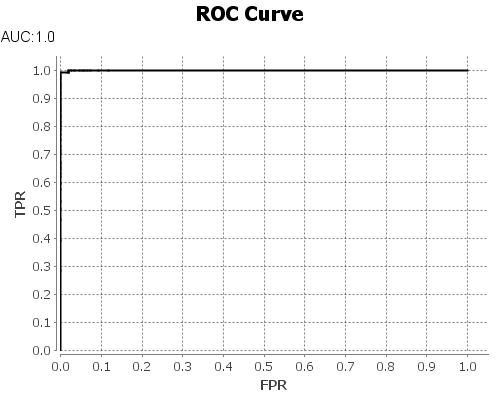

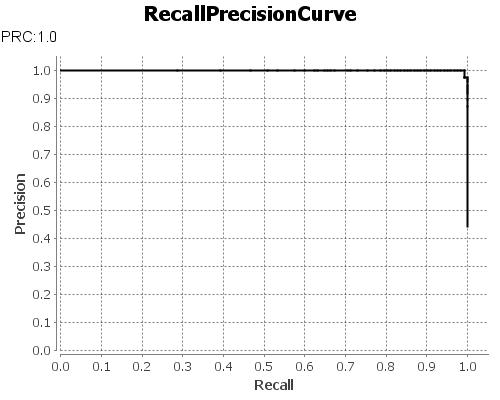

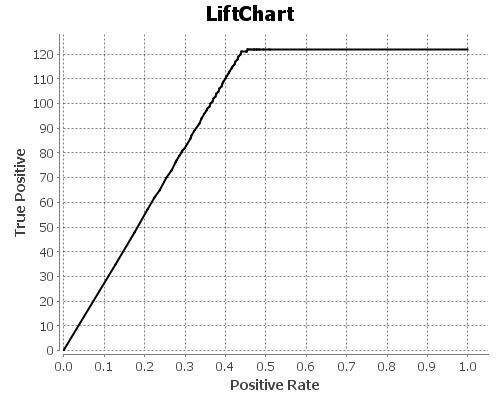

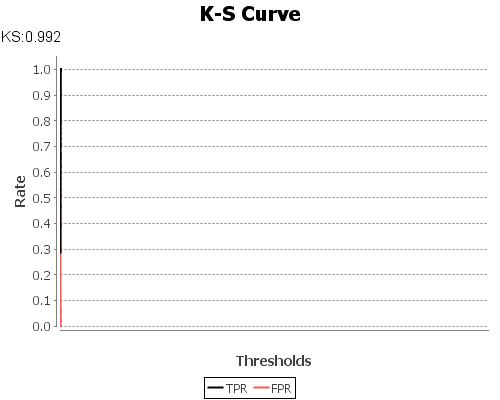

In [12]:
AkSourceBatchOp()\
    .setFilePath(DATA_DIR + SVM_PRED_FILE)\
    .link(
        EvalBinaryClassBatchOp()\
            .setPositiveLabelValueString("1")\
            .setLabelCol(LABEL_COL_NAME)\
            .setPredictionDetailCol(PRED_DETAIL_COL_NAME)\
            .lazyPrintMetrics()
            .lazyCollectMetrics(
                lambda binaryClassMetrics:(
                    binaryClassMetrics.saveRocCurveAsImage(
                        DATA_DIR + "svm_roc.jpg", True),
                    binaryClassMetrics.saveRecallPrecisionCurveAsImage(
                        DATA_DIR + "svm_recallprec.jpg", True),
                    binaryClassMetrics.saveLiftChartAsImage(
                        DATA_DIR + "svm_lift.jpg", True),
                    binaryClassMetrics.saveKSAsImage(
                        DATA_DIR + "svm_ks.jpg", True)
                )
            )
    )

BatchOperator.execute()